<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/convnets/EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper: EfficientNetV2: Smaller Models and Faster Training by Mingxing Tan, Quoc V. Le

Training efficiency has gained significant interests recently. For instance,
NFNets aim to improve training efficiency by removing the expensive batch normalization;
Several recent works focus on improving training speed by adding attention layers into
convolutional networks (ConvNets); Vision Transformers improves training efficiency on
large-scale datasets by using Transformer blocks. However, these methods often come with
significant overheads.

To develop these models, it uses a combination of training-aware neural search(NAS) and
scaling, to jointly optimize training speed and parameter efficiency.

Drawbracks of previous version of EfficientNets

1. training with very large image sizes is slow.
2. depthwise convolutions are slow in early layers.
3. equally scaling up every stage is sub-optimal.

Whats New With EfficientNetV2

Based on the above observations, V2 is designed on a search space enriched with additional
ops such as Fused-MBConv, and apply training-aware NAS and scaling to jointly optimize model
accuracy, training speed, and parameter size. EfficientNetV2, train up to 4x faster than
prior models, while being up to 6.8x smaller in parameter size.

To further increase the training speed, it uses progressive increase image size, previously
done by FixRes, Mix&Match. The only difference between the current approach from the previous
approach is the use of adaptive regularization as the image size is increased.


Additional Information:¶

Fused MBCONV Block:

> Same as MBCONV Block except the fact that Depthwise Convolution layer is replaced with normal Convolution layer.

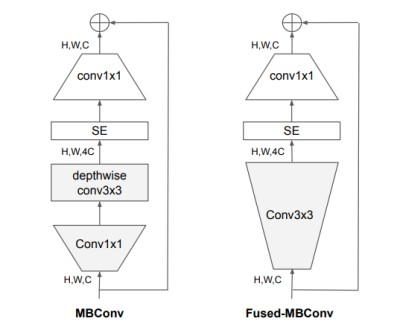

Progressive Learning:

> According to the paper, The author hypothesized that low resolution images needs week regularizer and high resolution images requires strong regularizer while training to achieve the best accuracy.

> The Progressive learning method is you start the training with small size images and weak augmentaions to learn the simpler features fast and easily first and then progressively increase the image size but also introduce the strong augmentations to make the learning difficult for the model. The augmentations used by the authors are Dropout, RandAugment, and Mixup.

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary


In [ ]:
Eff_V2_SETTINGS = {
    # expansion factor, k, stride, n_in, n_out, num_layers, use_fusedMBCONV
    's' : [
        [1, 3, 1, 24, 24, 2, True],
        [4, 3, 2, 24, 48, 4, True],
        [4, 3, 2, 48, 64, 4, True],
        [4, 3, 2, 64, 128, 6, False],
        [6, 3, 1, 128, 160, 9, False],
        [6, 3, 2, 160, 256, 15, False]
    ],

    'm' : [
        [1, 3, 1, 24, 24, 3, True],
        [4, 3, 2, 24, 48, 5, True],
        [4, 3, 2, 48, 80, 5, True],
        [4, 3, 2, 80, 160, 7, False],
        [6, 3, 1, 160, 176, 14, False],
        [6, 3, 2, 176, 304, 18, False],
        [6, 3, 1, 304, 512, 5, False]
    ],

    'l' : [
        [1, 3, 1, 32, 32, 4, True],
        [4, 3, 2, 32, 64, 7, True],
        [4, 3, 2, 64, 96, 7, True],
        [4, 3, 2, 96, 192, 10, False],
        [6, 3, 1, 192, 224, 19, False],
        [6, 3, 2, 224, 384, 25, False],
        [6, 3, 1, 384, 640, 7, False]
    ]
}

A simple Convolution + Batch Normalization + Activation Class

In [ ]:

class ConvBnAct(nn.Module):
    def __init__(self,ch_in,ch_out,kernel_size = 3,stride = 1,padding = 0,groups = 1,act = True,bn = True,bias = False):
        super(ConvBnAct,self).__init__()
        self.conv = nn.Conv2d(ch_in,ch_out,kernel_size,stride,padding = padding, groups = groups,bias = bias)
        self.bn = nn.BatchNorm2d(ch_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
    def forward(self,x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.activation(out)
        return out


Squeeze and Excitation Class

In [ ]:
class SqueezeAndExcitation(nn.Module):
    def __init__(self,ch_in,reduced_dim):
        super(SqueezeAndExcitation,self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Conv2d(ch_in,reduced_dim,kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim,ch_in,kernel_size = 1),
            nn.Sigmoid()
        )
    def forward(self,x):
        y = self.squeeze(x)
        y = self.excitation(y)
        return x * y

Stochastic Depth Class

In [ ]:
class StochasticDepth(nn.Module):
    def __init__(self,survival_prob = 0.8):
        super(StochasticDepth,self).__init__()
        self.p = survival_prob
    def forward(self,x):
        if not self.training:
            return x
        binary_tensor = torch.randn(x.size(0),1,1,1,device = x.device) < self.p

        return torch.div(x,self.p) * binary_tensor


MBCONV Class

In [ ]:
class MBCONV(nn.Module):
    def __init__(self,
                 ch_in,
                 ch_out,
                 kernel_size = 3,
                 stride = 1,
                 expansion_factor = 4,
                 reduction_factor = 4,# SqueezeExcitation Block
                 survival_prob = 0.8): # StochasticDepth Block
        super(MBCONV,self).__init__()
        reduced_dim  = int(ch_in // 4)
        expanded_dim = int(ch_in * expansion_factor)
        padding = (kernel_size - 1) // 2

        self.use_residual = (ch_in == ch_out) and (stride == 1)

        self.expand = nn.Identity() if expansion_factor == 1 else ConvBnAct(ch_in,expanded_dim,kernel_size = 1)
        #dw gconv
        self.depthwise_conv = ConvBnAct(expanded_dim,expanded_dim,kernel_size,stride = stride,padding = padding,groups = expanded_dim)
        #se
        self.se = SqueezeAndExcitation(expanded_dim,reduced_dim)
        #stochastic depth
        self.droplayers = StochasticDepth(survival_prob)
        #pw conv
        self.pointwise_conv = ConvBnAct(expanded_dim,ch_out,kernel_size = 1,act = False)
    def forward(self,x):
        residual = x.clone()
        out = self.expand(x)
        out = self.depthwise_conv(out)
        out = self.se(out)
        out = self.pointwise_conv(out)
        if self.use_residual:
            out = self.droplayers(out)
            out += residual
        return out

In [ ]:
# fb = MBCONV(32,64)
# summary(fb,(32,224,224))

Fused-MBCONV Class

In [ ]:
class FusedMBCONV(nn.Module):
    def __init__(self,
                 ch_in,
                 ch_out,
                 kernel_size = 3,
                 stride = 1,
                 expansion_factor = 4,
                 reduction_factor = 4,
                 survival_prob = 0.8
                 ):
        super(FusedMBCONV,self).__init__()
        reduced_dim = int(ch_in // reduction_factor)
        expanded_dim = int(ch_in * expansion_factor)
        padding = (kernel_size - 1) // 2

        self.use_residual = (ch_in == ch_out) and (stride == 1)

        self.conv = ConvBnAct(ch_in,expanded_dim,kernel_size,stride = stride,padding = padding,groups = 1)
        self.se = SqueezeAndExcitation(expanded_dim,reduced_dim)
        self.drop_layers = StochasticDepth(survival_prob)
        self.pointwise_conv = nn.Identity() if expansion_factor == 1 else ConvBnAct(expanded_dim,ch_out,kernel_size =1,act = False)

    def forward(self,x):
        residual = x.clone()
        out = self.conv(x)
        out = self.se(out)
        out = self.pointwise_conv(out)
        if self.use_residual:
            out = self.drop_layers(out)
            out += residual
        return out

In [ ]:
# fb = FusedMBCONV(32,64)
# summary(fb,(32,224,224))

In [ ]:
class EfficientNetV2(nn.Module):
    def __init__(self,version = 's',dropout_rate = 0.2,n_classes = 10):
        super(EfficientNetV2,self).__init__()
        last_channel = 1280
        self.features = self._feature_extractor(version,last_channel)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(dropout_rate,inplace = True),
            nn.Linear(last_channel,n_classes)
        )
    def forward(self,x):
        out = self.features(x)
        out = self.classifier(out)
        return out


        return nn.Sequential(*layers)

    def _feature_extractor(self,version,last_channel):
        config = Eff_V2_SETTINGS[version]
        layers = []
        layers.append(ConvBnAct(3,config[0][3],kernel_size = 3,stride = 2,padding = 1))

        for (expansion_factor, k, stride, n_in, n_out, num_layers, use_fused) in config:
            if use_fused:
                layers += [
                    FusedMBCONV(
                        n_in if repeat == 0 else n_out,
                        n_out,
                        kernel_size = k,
                        stride =stride if repeat == 0 else 1,
                        expansion_factor= expansion_factor
                    )
                    for repeat in range(num_layers)
                ]
            else:
                layers +=[
                    MBCONV(n_in if repeat == 0 else n_out,
                           n_out,
                           kernel_size = k,
                           stride = stride if repeat == 0 else 1,
                           expansion_factor= expansion_factor
                           )
                    for repeat in range(num_layers)
                ]
        layers.append(ConvBnAct(config[-1][4],last_channel,kernel_size = 1))
        return nn.Sequential(*layers)

In [ ]:
def test(version = 's', num_classes = 1000):
    net = EfficientNetV2(version = version, n_classes= num_classes)
    x = torch.rand(4, 3, 224, 224)
    y = net(x)
    print(y.size())

test()

torch.Size([4, 1000])
